In [1]:
from glob import glob
import os
import re

import torch
import numpy as np

import matplotlib.pyplot as plt

from functools import partial

from tqdm.notebook import tqdm

from tasks.mnist import mnist_256, mnist_full
from model import Model

from mnist_series import evaluate

from viz.model_viz import graph_from_model, draw_model_graph

import pandas as pd

import seaborn as sns

In [2]:
def model_paths():
    for p in glob('mnist_study_2/*'):
        f = os.path.join(p, 'model.pt')
        if os.path.exists(f):
            yield f

In [3]:
def dist_uniform(a, b, size):
    sample = np.random.uniform(a, b, tuple(size)).astype('float32')
    return torch.from_numpy(sample)


def dist_normal(mu, sigma, size):
    sample = np.random.normal(mu, sigma, tuple(size)).astype('float32')
    return torch.from_numpy(sample)


def dist_lognormal(mu, sigma, size):
    sample = np.random.lognormal(mu, sigma, tuple(size)).astype('float32')
    return torch.from_numpy(sample)


distributions = dict(
    uniform=partial(dist_uniform, -2, 2),
    constant=torch.ones,
    lognormal=partial(dist_lognormal, 0, 0.5),
)


def draw_shared_weight(dist, size=(20,)):
    return distributions[dist](size)

In [4]:
test_data = {
    256: mnist_256(test=True, batch_size=100),
    784: mnist_full(test=True, batch_size=100)
}

In [5]:
def evaluate_model(visualize=True, **params):
    #print ("Evaluating model:", params)
    d = torch.load(params['model_path'])
    shared_weight = draw_shared_weight(params['weight_dist'])
    model = Model.from_dict(shared_weight, d['state'])
    
    model.cleanup()
    
    #print (model.layer_sizes())
    
    if visualize:
        g = graph_from_model(model)
        draw_model_graph(g)
        plt.gcf().set_size_inches(10,4)

        plt.show()
    
    acc = evaluate(model, test_data[params['mnist_size']])
    #print(acc)
    
    row = dict(params)
    row['accuracy'] = acc
    row['layer_sizes'] = model.layer_sizes().numpy()
    return row

In [6]:
pattern = re.compile(".*/MNIST-(\d{3})_(growing|static)-(ste|ab|hybrid)_100epochs-64_1_(.*)-5_(\d)/model.pt")

data = list()

for p in tqdm(list(model_paths())):
    params = {k: v for k, v in zip(('mnist_size', 'growing', 'update_mechanism', 'weight_dist', 'repetition'), pattern.match(p).groups())}
    params['growing'] = params['growing'] == 'growing'
    params['repetition'] = int(params['repetition'])
    params['mnist_size'] = int(params['mnist_size'])
    params['model_path'] = p
    
    data.append(evaluate_model(visualize=False, **params))
    
    
    

In [7]:
df = pd.DataFrame(data)

In [8]:
df.to_csv('mnist_trial_2_data.csv')

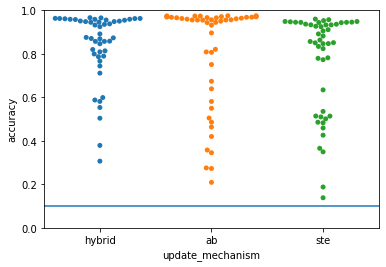

In [9]:
baseline=0.1
sns.swarmplot(x='update_mechanism', y='accuracy', data=df)
plt.ylim([0,1])
plt.axhline(y=baseline, label="baseline")
plt.show()

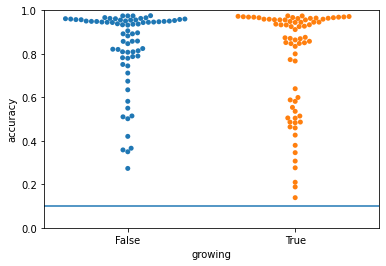

In [10]:
baseline=0.1
sns.swarmplot(x='growing', y='accuracy', data=df)
plt.ylim([0,1])
plt.axhline(y=baseline, label="baseline")
plt.show()

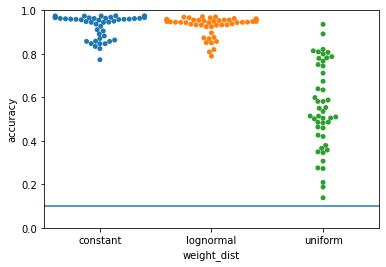

In [11]:
baseline=0.1
sns.swarmplot(x='weight_dist', y='accuracy', data=df)
plt.ylim([0,1])
plt.axhline(y=baseline, label="baseline")
plt.show()

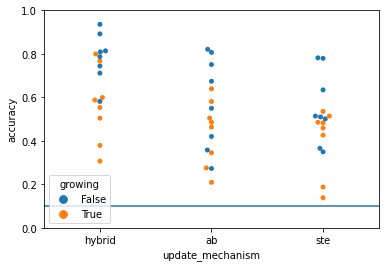

In [12]:
uniform_df = df[df['weight_dist']=='uniform']
baseline=0.1
sns.swarmplot(x='update_mechanism', y='accuracy', data=uniform_df, hue='growing')
plt.ylim([0,1])
plt.axhline(y=baseline, label="baseline")
plt.show()

In [13]:
best_row = uniform_df.loc[uniform_df['accuracy'].idxmax()]

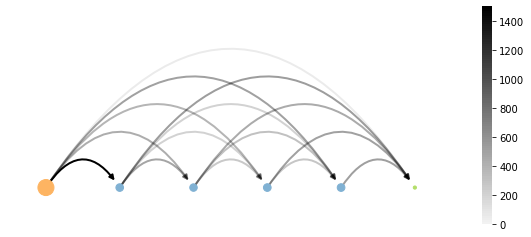

{'mnist_size': 256,
 'growing': False,
 'update_mechanism': 'hybrid',
 'weight_dist': 'uniform',
 'repetition': 2,
 'model_path': 'mnist_study_2/MNIST-256_static-hybrid_100epochs-64_1_uniform-5_2/model.pt',
 'accuracy': 0.9366450000000005,
 'layer_sizes': array([58., 56., 59., 59.], dtype=float32)}

In [14]:
evaluate_model(visualize=True, **dict(best_row))